In [81]:
from fastai.vision.all import *
from fastai.vision.gan import *
from fastai.distributed import *
from fastai.metrics import error_rate
from fastai.callback.tracker import SaveModelCallback
import torch 
from fastai.metrics import *


from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
import torchvision.transforms as T
from torchvision import datasets, transforms, models
from torchvision.transforms.functional import *

from collections import defaultdict, deque
import itertools

import matplotlib.pyplot as plt
import numpy as np
import torch.utils.data
import torch

from torchvision.datasets.imagenet import ImageNet

import random

from skimage import io
from PIL import *

import time

In [195]:
H = 32
W= 32
bs=5

transform = T.Compose([
T.Resize((H,W)),
T.ToTensor(),
T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [100]:
class Curating_of_attention_mask(nn.Module):
    def __init__(self, width=32, height=32, grid_l=2):
        super().__init__()
        self.grid_l = grid_l
        self.width = width
        self.height = height
        self.grids_list = self.grids_list(self.width, self.height, self.grid_l)
        self.grids_matrix = self.grids_matrix(self.width, self.height, self.grid_l)
        
        
    def grids_list(self, width, height, grid_l): #COMPUTED ONCE BEFORE TRAINING
        w = width
        h = height
        qt_hor_grids = w//grid_l
        qt_ver_grids = h//grid_l
        qtd_grids = qt_hor_grids*qt_ver_grids
        c = 0
        grids_list = []
        for i in range(qtd_grids):
            hor_pos = i//qt_hor_grids
            ver_pos = c
            c = c+1
            grid = [hor_pos,ver_pos]
            grids_list.append(grid)
            if c == qt_ver_grids:
                c=0
        return grids_list
        
        
    def grids_matrix(self, width, height, grid_l):

        w = width
        h = height
        len_input_seq = h*w
        qt_hor_grids = w//grid_l
        qt_ver_grids = h//grid_l


        grid_list = []
        for i in range(h):
            row_grid_list = []
            preliminar_ver_grid = i//grid_l
            if preliminar_ver_grid != 0:
                preliminar_ver_grid = preliminar_ver_grid*qt_hor_grids

            for h in range(w):
                preliminar_grid = h//grid_l+preliminar_ver_grid
                row_grid_list.append(preliminar_grid)

            grid_list.append(row_grid_list)
        grid_matrix = torch.tensor(np.array(grid_list))

        return grid_matrix
        
        
    def img_patches(self, batch, grid_l):
        #torch.Tensor.unfold(dimension, size, step)
        #slices the images into grid_l*grid_l size patches
        patches = batch.data.unfold(1, 3, 3).unfold(2, grid_l, grid_l).unfold(3, grid_l, grid_l)
        a, b, c, d, e, f, g = patches.shape
        patches = patches.reshape(a, c, d, e, f, g)
        #print(patches.shape)
        return patches


    def grid_gram_matrix(self, patches):

        a, b, c, d, e, f = patches.shape
        # a=batch size
        # b=horizontal patches
        # c = vertical patches
        # d=number of feature maps
        # (e,f)=dimensions of a f. map (N=e*f)

        features = patches.reshape(a * b * c, d, e*f)  # resise F_XL into \hat F_XL
        #print(features.shape)
        # compute the gram product

        G = torch.mm(features[0], features[0].t())

        for i in range(1,a*b*c):
            g = torch.mm(features[i], features[i].t())
            G= torch.cat((G, g), 0)


        G = G.div(d * e * f).reshape(a, b, c, d, d)

        # we 'normalize' the values of the gram matrix
        # by dividing by the number of element in each feature maps.

        return G



    def gram_dist_matrix(self, batch, grid_l):
        patches = self.img_patches(batch, grid_l)
        #print(patches.shape)
        Grid = self.grid_gram_matrix(patches)
        #print(Grid.shape)
        bs = batch.shape[0]
        #print(bs)
        MSE = nn.MSELoss()

        mse_grid = []
        for k in range(bs):
            dist_grid = []
            for g in range(len(self.grids_list)):
                dist_pair_list = []
                for n in range(len(self.grids_list)):
                    dist_pair_list.append(MSE(Grid[k][self.grids_list[g][0]][self.grids_list[g][1]], Grid[k][self.grids_list[n][0]][self.grids_list[n][1]]))
                dist_grid.append(dist_pair_list)
            mse_grid.append(dist_grid)

        dist_matrix = torch.tensor(mse_grid)
        #dist_matrix = torch.tensor(np.array(mse_grid))

        for i in range(bs):
            dist_matrix[i] = dist_matrix[i].view(dist_matrix[i].size(0), -1)
            dist_matrix[i] -= dist_matrix[i].min(1, keepdim=True)[0]
            dist_matrix[i] /= dist_matrix[i].max(1, keepdim=True)[0]
            dist_matrix[i] = dist_matrix[i].view(1, len(self.grids_list), len(self.grids_list))

        return dist_matrix


    def penalty_factor(self, dist_matrix, penalty_factor="1", alpha=1):
        if penalty_factor == "1" or penalty_factor =="distraction":
            pf_matrix = ((dist_matrix+1))**alpha
            return pf_matrix
        if penalty_factor == "2" or penalty_factor =="misdirection":
            pf_matrix = alpha*((torch.max(dist_matrix)//2)-dist_matrix+0.1)**3
            return pf_matrix


    def penalty_matrix(self, width, height, grid_matrix, dist_matrix, grid_l):
        bs,_,_ = dist_matrix.shape
        pep = []
        for s in range(bs):
            pf_matrix = self.penalty_factor(dist_matrix[s], penalty_factor="1", alpha=1)
            w = width
            h = height

            qt_hor_grids = w//grid_l
            qt_ver_grids = h//grid_l
            qtd_grids = qt_hor_grids*qt_ver_grids

            penalty_mask = []
            for i in range(qtd_grids):
                ref_column = pf_matrix[i]
                p_matrix = grid_matrix.type(torch.FloatTensor)
                for j in range(1,len(ref_column)):
                    #print(float(j))
                    p_matrix[p_matrix==j]=float(ref_column[j])
                p_matrix[p_matrix==0]=float(ref_column[0])
                penalty_mask.append(p_matrix)

            #print(len(penalty_mask))    

            penalty_enc = []
            for i in range(h):
                penalty_row = []
                for j in range(w):
                    #print(grid_matrix[i,j])
                    #print(penalty_mask[grid_matrix[i,j]].shape)
                    penalty_row.append(penalty_mask[grid_matrix[i,j]])
                    #print(len(penalty_row))
                generic_tensor = Tensor(h,w)
                penalty_row_tensor = torch.cat(penalty_row, out=generic_tensor)
                penalty_enc.append(penalty_row_tensor)
                #print(penalty_row_tensor.shape)
                #break

            b = torch.Tensor(h, w, h, w)
            c=torch.cat(penalty_enc, out=b)
            c = c.view(h, w, h, w)
            pep.append(c)

        d = torch.Tensor(bs, h, w, h, w)
        penalty_encoding_pattern = torch.cat(pep, out=d)
        penalty_encoding_pattern = penalty_encoding_pattern.view(bs, h, w, h, w)

        return penalty_encoding_pattern
        
    def forward(self, batch):
        
        batch = batch.unsqueeze(0)
        
        dist_matrix = self.gram_dist_matrix(batch, self.grid_l)
        penalty_mask = self.penalty_matrix(self.width, self.height, self.grids_matrix, dist_matrix, self.grid_l)
        
        pattn = penalty_mask.squeeze(0)
        
        return pattn

In [136]:
class CustomCifar(datasets.CIFAR10):
    def __init__(self, path, transforms, width=32, height=32, grid_l=2, size=None, train=True):
        super().__init__(path)
        self.width = width
        self.height = height
        self.transforms = transforms
        self.train = train
        if size == None:
            if train == True:
                self.size = 50000
            else:
                self.size = 10000
        else:
            self.size = size
        self.indexes = self.create_idx()
        self.attention_mask = Curating_of_attention_mask(width, height, grid_l)
        self.pattn_dict = self.create_labels()

    def create_idx(self):
        indexes = {}
        i = 0
        max_len = 50000
        if self.train != True:
            max_len = 10000
        while len(indexes) < (self.size):
            r=random.randint(0,max_len)
            if r not in indexes.values(): 
                indexes[i] = r
                i +=1

        return indexes
    
    def create_labels(self):
        
        transform = T.Compose([
        T.Resize((self.height,self.width)),
        T.ToTensor(),
        T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])
        
        attention_labels = {}
        for i in range(len(self.indexes)):
            index = self.indexes[i]
            im, _ = super().__getitem__(index)
            pattn = self.attention_mask(self.transforms(im))
            attention_labels[i] = pattn

        return attention_labels

    def __len__(self):
         return len(self.indexes)
        
    def __getitem__(self, index):

        #index = self.indexes[index]
        im, label = super().__getitem__(self.indexes[index])
        pattn = self.pattn_dict[index]
        return self.transforms(im), (pattn, label)

In [137]:
ds = CustomCifar(path='./data', transforms=transform, size = 50)

In [144]:
ds

Dataset CustomCifar
    Number of datapoints: 50
    Root location: ./data
    Split: Train
    Compose(
    Resize(size=(32, 32), interpolation=PIL.Image.BILINEAR)
    ToTensor()
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
)

In [147]:
torch.save(ds, 'customCifar.tar')

In [ ]:
def CifarDataloader(path_train, path_val=None): #
    if path_val = None:
        db = torch.load('customCifar.tar')
        train_size = int(len(db)*0.8)
        val_size = int(len(db)*0.2)
        remainder = len(db)-train_size - val_size
        train, valid, _ = torch.utils.data.random_split(Loaded_db, [train_size, val_size, remainder])
        
        train_dl = load.DataLoader(train,batch_size=5)
        valid_dl = load.DataLoader(valid,batch_size=5)
        dld = ImageDataLoaders(train_dl, valid_dl, device='cuda')
        
        return dld

In [149]:
Loaded_db = torch.load('customCifar.tar')

In [168]:
i = 1
print("Input shape", Loaded_db[i][0].shape)
print("Pattn shape", Loaded_db[i][1][0].shape)
print("Label", Loaded_db[i][1][1])

Input shape torch.Size([3, 32, 32])
Pattn shape torch.Size([32, 32, 32, 32])
Label 1


In [189]:
len(Loaded_db)

50

In [192]:
int(len(db)*0.8)
int(len(db)*0.2)
len(db)-int(len(db)*0.8)-int(51*0.2)

1

In [156]:
from fastai.data import load
dloader = load.DataLoader(dataset=Loaded_db, batch_size=5)

In [176]:
print("Dataloader size:",len(dloader.data))
#dloader.dataset[0]

Dataloader size: 50000


In [177]:
train_size = 40
test_size = 10
remainder = 0
train, valid, _ = torch.utils.data.random_split(Loaded_db, [train_size, test_size, remainder])

In [194]:
train_dl = load.DataLoader(train,batch_size=5)
valid_dl = load.DataLoader(valid,batch_size=5)
dld = ImageDataLoaders(train_dl, valid_dl, device='cuda')

In [182]:
class Curating_of_attention_loss(nn.Module):
    def __init__(self, ):
        super().__init__()
 
    def forward(self, sattn, pattn):
        #Computing the Attention Loss
        att_loss = sattn*pattn
        Latt = torch.sum(att_loss)

        return Latt


class CriticLoss(nn.Module):
    def __init__(self, beta=0.0000005, sigma=1):
        super(CriticLoss, self).__init__()
        self.beta = beta
        self.sigma = sigma

    def forward(self, preds, label):
        #print("Critic Loss")
        crossEntropy = nn.CrossEntropyLoss()
        classificationLoss = crossEntropy(preds[0], label[1])

        LCA = Curating_of_attention_loss()
        Latt = LCA(preds[1], label[0])
        
        Lc = self.sigma*classificationLoss - self.beta*Latt
        
        return Lc
    
#[x, sattn, pattn, inputs, x0]

In [183]:
from models.utils.joiner2 import Joiner
#from models.utils.new_losses import CriticLoss
from models.utils.metrics import Accuracy

model = Joiner(num_encoder_layers = 6, nhead=8, backbone = False, num_classes = 10, bypass=False, hidden_dim=256, 
          batch_size=bs, image_h=H, image_w=W,grid_l=2,penalty_factor="2")

In [184]:
critic_loss = CriticLoss()

In [ ]:
dl

In [187]:
learner = Learner(dld, model, loss_func=critic_loss, metrics=[Accuracy])

SuggestedLRs(lr_min=3.0199516913853586e-06, lr_steep=2.0892961401841603e-05)

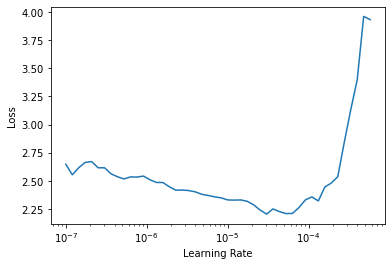

In [188]:
learner.lr_find()

In [197]:
for i in range(1001):
    if i%50 == 0:
        print(i)

0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
